# 資料前處理


1.   大部分資料峰度偏大>取log
2.   標準化
3.   填補遺漏值
4.   查看關聯性





### 探索式資料分析

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc


data = pd.read_csv('cs-training.csv',index_col=0)
data = data.reset_index().iloc[:,1:] #重設索引(把原本的index刪除)
data.columns = ["Target","RevolveUtilize","age","30-59DaysPastDue","DebtRatio","MonIncome",
                "NOfCreditLineAndLoan","90DaysLate", "NRealEstateLoans","60-89DaysPastDue","NOfDependents"]
def profiling():
  col = ['mean', 'std', 'min', '50%', 'max']
  summary = data.describe()
  na = pd.DataFrame(data.isnull().sum()/len(data)*100,columns = ['NA(%)']).T #計算缺失率
  skew = pd.DataFrame(data.skew(),columns=["skewness"]).T #偏度
  kurt = pd.DataFrame(data.kurtosis(),columns=["kurtosis"]).T #峰度
  print(tabulate(pd.concat([na, summary.loc[col], skew, kurt]), headers=data.columns))
profiling()

             Target    RevolveUtilize         age    30-59DaysPastDue      DebtRatio        MonIncome    NOfCreditLineAndLoan    90DaysLate    NRealEstateLoans    60-89DaysPastDue    NOfDependents
--------  ---------  ----------------  ----------  ------------------  -------------  ---------------  ----------------------  ------------  ------------------  ------------------  ---------------
NA(%)      0                 0           0                   0              0            19.8207                      0            0                    0                  0                2.616
mean       0.06684           6.04844    52.2952              0.421033     353.005      6670.22                        8.45276      0.265973             1.01824            0.240387         0.757222
std        0.249746        249.755      14.7719              4.19278     2037.82      14384.7                         5.14595      4.1693               1.12977            4.15518          1.11509
min        0       

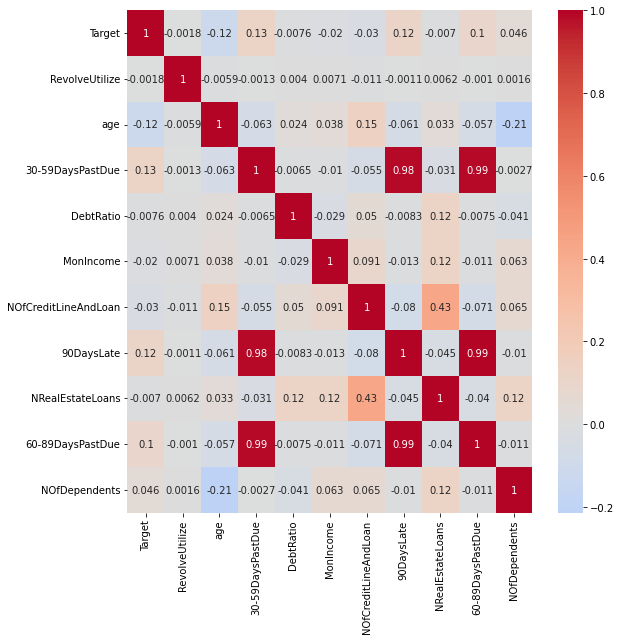

In [ ]:
plt.figure(figsize=(9,9))
cor = sns.heatmap(data.corr(), annot = True,center=0, cmap='coolwarm'); # cmap="YlGnBu"
cor.figure.tight_layout()
#figure = cor.get_figure()
#cor.figure.savefig('.//graph//heatmap', dpi=300)
plt.show()

### 取Log

In [ ]:
for i in [1,3,4,5,7,8,9]:
    data.iloc[:,i] = np.log(data.iloc[:,i]+ 
        1/(10**(-int(format(np.nanmean(data.iloc[:,i]),'.1E')[-3:])+6)))
profiling()


             Target    RevolveUtilize         age    30-59DaysPastDue    DebtRatio    MonIncome    NOfCreditLineAndLoan    90DaysLate    NRealEstateLoans    60-89DaysPastDue    NOfDependents
--------  ---------  ----------------  ----------  ------------------  -----------  -----------  ----------------------  ------------  ------------------  ------------------  ---------------
NA(%)      0                  0          0                    0           0            19.8207                  0             0               0                       0               2.616
mean       0.06684           -2.83144   52.2952             -13.4852     -0.148603      8.31347                 8.45276     -15.1953         -4.94515               -15.2836          0.757222
std        0.249746           3.51678   14.7719               6.04103     3.84054       2.01276                 5.14595       3.80952         6.8743                  3.61683         1.11509
min        0                -13.8155     0       

### 標準化

In [ ]:
#先看有哪些遺漏值
MonIncome_col=pd.DataFrame(np.where(np.isnan(data['MonIncome']),1,0))
NOfDependents_col=pd.DataFrame(np.where(np.isnan(data['NOfDependents']),1,0))

In [ ]:
Y = data.iloc[:,0]
X = data.iloc[:,1:]
X = (X - X.mean()) / X.std()
X = X.fillna(0) #在遺漏值填0
data = pd.concat([Y, X],axis = 1)
profiling()

             Target    RevolveUtilize          age    30-59DaysPastDue     DebtRatio     MonIncome    NOfCreditLineAndLoan    90DaysLate    NRealEstateLoans    60-89DaysPastDue    NOfDependents
--------  ---------  ----------------  -----------  ------------------  ------------  ------------  ----------------------  ------------  ------------------  ------------------  ---------------
NA(%)      0              0             0                  0             0             0                       0             0                   0                   0                0
mean       0.06684        3.67114e-17   9.0381e-17        -7.38017e-16  -3.30047e-17  -1.22071e-16             7.40859e-17  -4.37457e-16         7.27122e-17        -1.16955e-15      4.16378e-17
std        0.249746       1             1                  1             1             0.895428                1             1                   1                   1                0.986833
min        0             -3.12333      -3.5

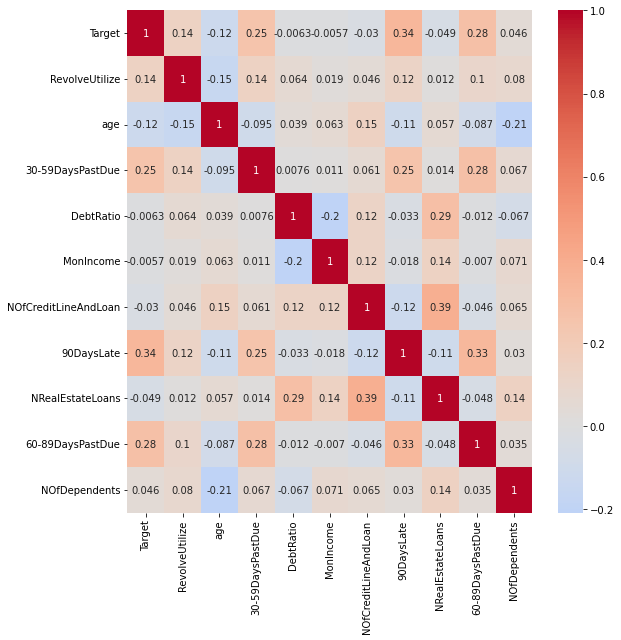

In [ ]:
plt.figure(figsize=(9,9))
cor = sns.heatmap(data.corr(), annot = True,center=0, cmap='coolwarm'); # cmap="YlGnBu"
cor.figure.tight_layout()
#figure = cor.get_figure()
#cor.figure.savefig('.//graph//heatmap', dpi=300)
plt.show()

### 填補遺漏值

In [ ]:
data.insert(6, "ISNALogMonIncome",MonIncome_col)
data.insert(12, "ISNANOfDependents",NOfDependents_col)
profiling()

             Target    RevolveUtilize          age    30-59DaysPastDue     DebtRatio     MonIncome    ISNALogMonIncome    NOfCreditLineAndLoan    90DaysLate    NRealEstateLoans    60-89DaysPastDue    NOfDependents    ISNANOfDependents
--------  ---------  ----------------  -----------  ------------------  ------------  ------------  ------------------  ----------------------  ------------  ------------------  ------------------  ---------------  -------------------
NA(%)      0              0             0                  0             0             0                      0                    0             0                   0                   0                0                       0
mean       0.06684        3.67114e-17   9.0381e-17        -7.38017e-16  -3.30047e-17  -1.22071e-16            0.198207             7.40859e-17  -4.37457e-16         7.27122e-17        -1.16955e-15      4.16378e-17             0.02616
std        0.249746       1             1                  1        

### 查看成對關聯性

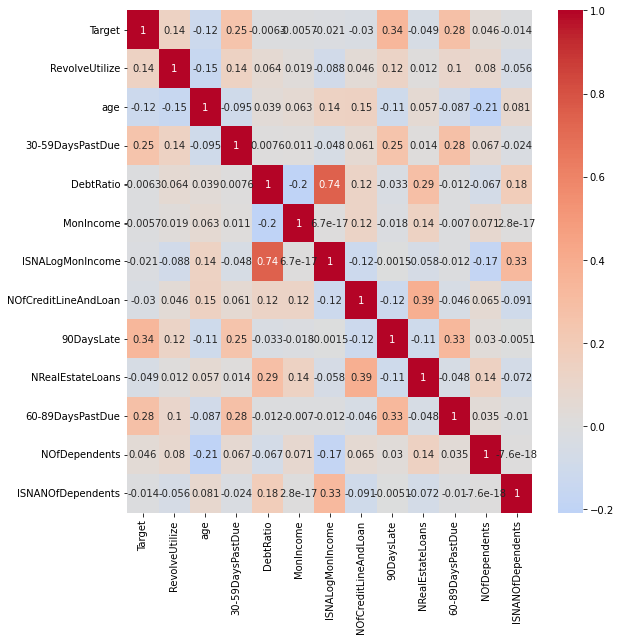

In [ ]:
plt.figure(figsize=(9,9))
cor = sns.heatmap(data.corr(), annot = True,center=0, cmap='coolwarm'); # cmap="YlGnBu"
cor.figure.tight_layout()
#figure = cor.get_figure()
#cor.figure.savefig('.//graph//heatmap', dpi=300)
plt.show()

# 演算法
> 先將train分成 80% train 及 20% test

> 使用三種演算法 :


1.   邏輯回歸
2.   隨機森林
3.   XGBoost

> 最後集成學習














### 分割Train

In [ ]:
X_train_data, X_test_data, Y_train_data, Y_test_data = train_test_split(X, Y, test_size=0.2, random_state=3)

In [ ]:
#轉成ndarray
X_train = X_train_data.to_numpy()
Y_train = Y_train_data.to_numpy().flatten()
X_test = X_test_data.to_numpy()
Y_test = Y_test_data.to_numpy().flatten()

### 演算法

邏輯迴歸

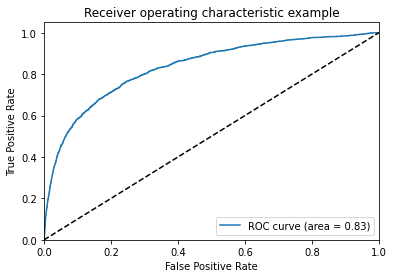

In [ ]:
clf_lr = LogisticRegression(penalty='l2', solver='sag', random_state=0)
clf_lr.fit(X_train, Y_train)    
y_pred_lg = clf_lr.predict(X_test)  
y_pred_lg[:100]


#AUC Curve
# Compute the predicted probabilities of the positive class
y_prob_lg = clf_lr.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(Y_test, y_prob_lg)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()  

Randon Forest

RandomForestClassifier(max_depth=2, random_state=0)


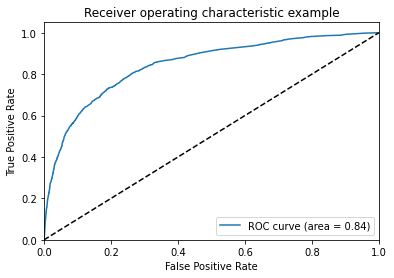

RandomForestClassifier(max_depth=2, random_state=0)


In [ ]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf_rf.fit(X_train, Y_train)
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf[:100]
print(clf_rf)

#AUC Curve
# Compute the predicted probabilities of the positive class
y_prob_lg = clf_rf.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(Y_test, y_prob_lg)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()  

print(clf_rf)

XGBoost

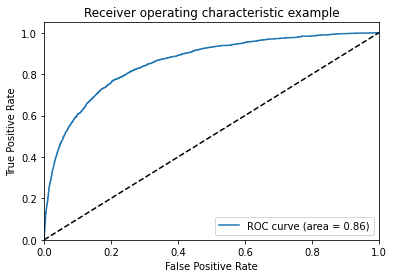

In [ ]:
# 建立 XGBClassifier 模型
xgboostModel = XGBClassifier(n_estimators=100, learning_rate= 0.3)
# 使用訓練資料訓練模型
xgboostModel.fit(X_train, Y_train)
# 使用訓練資料預測分類
y_pred_XG= xgboostModel.predict(X_test)
y_pred_XG[:100]



#AUC Curve
# Compute the predicted probabilities of the positive class
y_prob_lg = xgboostModel.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(Y_test, y_prob_lg)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()  

### 集成學習

In [ ]:
y_pred=xgboostModel+clf_rf+clf_lr
prnt(y_pred)
y_pred = (y_pred >= 2).astype(int)
fpr, tpr, threshold = roc_curve(Y_test,y_pred)
print(fpr, tpr, threshold)
auc1 = auc(fpr, tpr)
## Plot the result
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()

TypeError: ignored